In [1]:
import os
import pickle
from glob import glob

from entities.clip_annotations import ClipAnnotation
from entities.clip_dataset import FilteredClipDataset

results_dir = "/playpen-storage/levlevi/opr/fine-nba/src/statvu_align/__nba-plus-statvu-dataset__/statvu-aligned"
file_paths = glob(os.path.join(results_dir, "*", "*.pkl"))
ex_fp = file_paths[3]

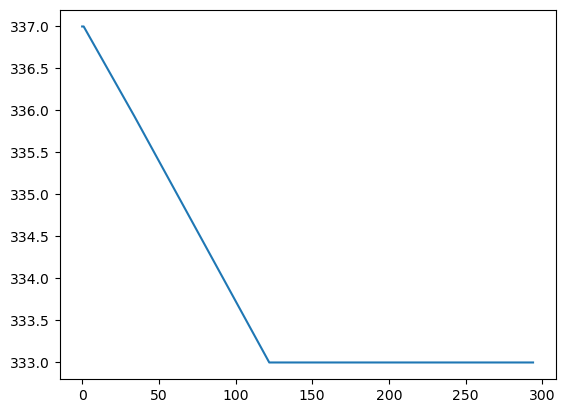

In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt

from typing import Optional, List
# goal: map each frame idx to a float val representing the time remaining


def re_time_remaining(text: str):
    """
    Matches any string showing a valid time remaining of 20 minutes or less
    assumes brodcasts use MM:SS for times > 1 minute, and SS.S for times < 1 minute
    """
    
    if text is None:
        return None
    time_remaining_regex = r"(20:00)|(0[0-9]?:[0-9][0-9](\.[0-9])?)|([1-9]:[0-5][0-9])|(1[0-9]:[0-5][0-9](\.[0-9])?)|([0-9]\.[0-9])|([1-5][0-9]\.[0-9])"
    result = text.replace(" ", "")
    match = re.match(time_remaining_regex, result)
    if match is not None and match[0] == result:
        return result
    return None


def convert_time_to_float(time_remaining):
    """
    Coverts valid time-remaining str
    to float value representation.
    Return None if time-remaining is invalid.

    Ex: '1:30' -> 90.
    """

    if time_remaining is None:
        return None
    minutes, seconds = 0.0, 0.0
    if ':' in time_remaining:
        time_arr = time_remaining.split(':')
        minutes = float(time_arr[0])
        seconds = float(time_arr[1])
    elif '.' in time_remaining:
        seconds = float(time_remaining)
    else:
        return None
    return (60.0 * minutes) + seconds


def post_process_time_remaining(arr: List[float], fps: int=30) -> List[float]:
    
    # 0. in-fill missing tr values
    # 1. find points where time-remaining decreases/changes
    # 2. interpolate between points of decrease    
    pass


def get_time_remaining_from_result(result) -> Optional[str]:
    """
    Convert an ultralytics results obj to predicted time remaining.
    """
    
    names = result.names
    boxes = result.boxes.cpu().numpy()
    classes = boxes.cls.tolist()
    xyxy = boxes.xyxy.tolist()
    predicted_str = ""
    char_dict = {}
    for pred_class, box in zip(classes, xyxy):
        char = names[pred_class]
        x1 = box[0]
        char_dict[x1] = char
    
    # print(char_dict)
    for key in sorted(char_dict.keys()):
        predicted_str += char_dict[key]
    return re_time_remaining(predicted_str)    


def interpolate_time_remaining(arr: List[float], fps:int = 30) -> List[float]:
    """
    Perform linear interpolatation of a "staircase" monotonically decreasing function.

    TL;DR: smoothly fill in the values between the whole number time-remaining vals scrapped off the game clock.
    """

    arr = arr.copy()
    grad_y = np.gradient(arr)
    inflection_points_y = np.argwhere(list(grad_y <= -.3))[::2]
    interpolated_arr = np.array(arr)
    interpolated_arr = np.interp(
        np.arange(len(arr)), 
        inflection_points_y[:, 0], 
        interpolated_arr[inflection_points_y][:, 0] - 1
        )
    return interpolated_arr


def convert_results_to_timeseries(results_fp: str) -> List[float]:

    assert results_fp.endswith(".pkl")
    with open(results_fp, 'rb') as f:
        data = pickle.load(f)
    arr = []
    for frame_idx, result in enumerate(data):
        predicted_tr: str = convert_time_to_float(get_time_remaining_from_result(result))
        arr.append(predicted_tr)
    
    # TODO: jank! handle no detected time remaining vals
    try:
        smoothed_results = interpolate_time_remaining(arr).tolist()
    except:
        return []
    return smoothed_results


plt.plot(convert_results_to_timeseries(ex_fp));

In [3]:
fp = "/playpen-storage/levlevi/opr/fine-nba/src/statvu_align/__nba-plus-statvu-dataset__/filtered-clip-annotations-with-video-info/17600/period1/17600_period1_1-_77131343_annotation_0.pkl"
ann = ClipAnnotation(fp)

In [4]:
print(ann.statvu_aligned_fp)

/mnt/mir/levlevi/nba-plus-statvu-dataset/statvu-aligned/17600/17600_period1_1-_77131343_0.pkl


In [7]:
import ujson as json

with open(ann.statvu_game_log_fp, 'r') as f:
    data = json.load(f)
    
data